In [2]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph", "tidyverse",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang", "simtrial", "ggrepel")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))
n_cores <- detectCores()
cluster <- makeCluster(32)  
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/3m_comparison.R')
source('Rfiles/Function.R')
source('Rfiles/get_opt_des.R')
clusterExport(cluster, "expo_gen_2stages")

## 1. Late Difference
#### $HR1 = 1, HR2 = 0.5$
####  $\textcolor{yellow}{H_0 : \lambda_0 = \lambda_1 = 1.2}$    
####  $\textcolor{yellow}{H_1 : \lambda_0 = 1.2,\ \lambda_1 = Piecewise\ Exponential}$
#### <span style="color:yellow">with a HR of 1 until around 1 year and then a HR of 0.5 onward.


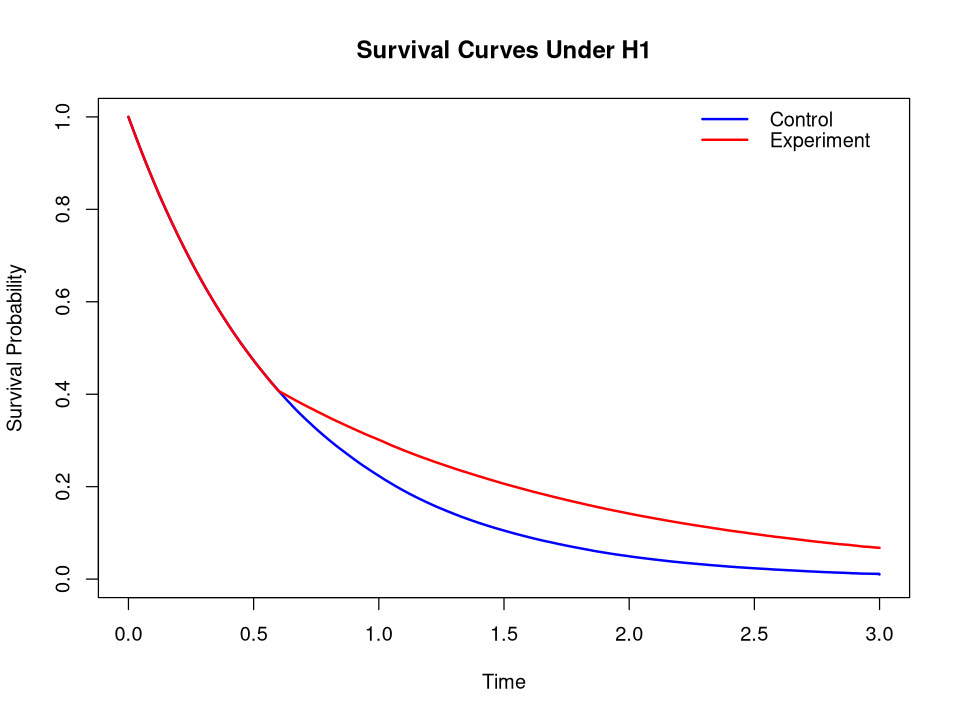

In [14]:
lambda_H0 <- 1.5
HR1 <- 1
HR2 <- 0.5
sim_size <- 8000 
n <- ceiling(200 / 2) 
r <- 100  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
change_time <- acc_time * 0.3 # The time point between HR1 and HR2
set.seed(2024)

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0,
                         dist = 'exp', cen_time = cen_time, arm = 0, interim = interim)
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                         dist = 'exp', cen_time = cen_time, arm = 1, interim = interim)                         
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                          dist = 'pcw_exp', cen_time = cen_time,HR1 = HR1, HR2 = HR2, 
                          change_time = change_time, arm = 1, interim = interim)

pre_data <- rbind(data_C[ , c(4,5,1)], data_E_H1[ , c(4,5,1)])
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])

options(repr.plot.width = 8, repr.plot.height = 6)
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

## 1.  Different Hazard Ratio (HR2)
#### $H0: \lambda_E = \lambda_C = 1.2$ is fixed.
#### $H1: \lambda_C = 1.2,\ \lambda_{E2} = 1.2*HR2$, where $\lambda_{E2}$ is the hazard of period 2. 
#### Fix HR1 = 1.2, Change HR2

In [ ]:
lambda_H0 <- 1.2
HR1 <- 1
HR2 <- 0.5
sim_size <- 5000 
N <- 200
n <- ceiling(N / 2) 
r <- 150   # patient recruit rate
acc_time <- N / r
cen_time <- 2
interim <- 0.7 * acc_time
change_time <- 1   # The time point between HR1 and HR2
set.seed(2024)
alpha <- 0.05

diff_hr2_LD <- foreach(HR2 = seq(0.5, 0.8, by = 0.05), .combine = rbind) %do%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(HR2, result$alpha, result$power, result$PET0, result$PET1)      
    }


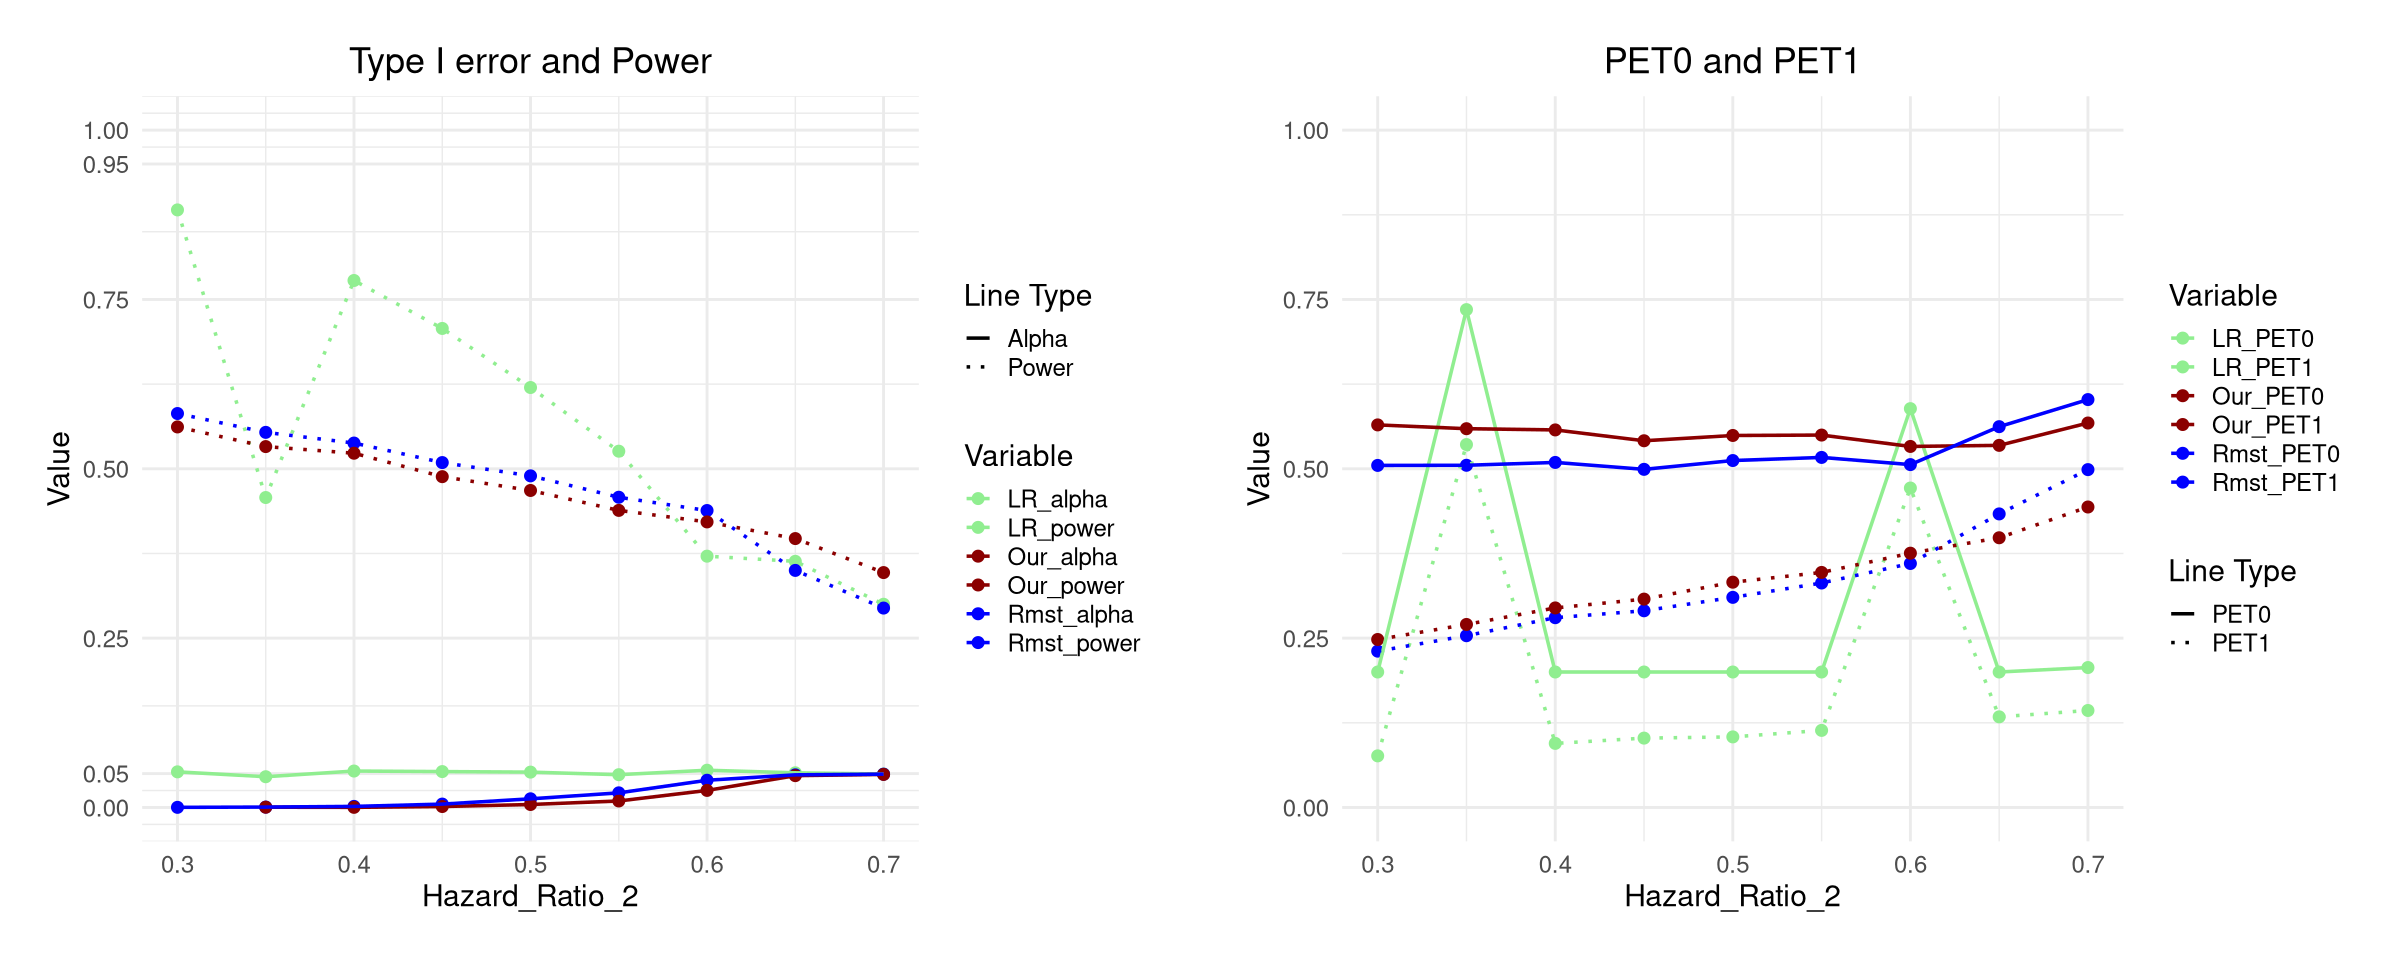

In [25]:
# save(diff_hr2_LD, file = '/home/r27user6/RMST_Code/RData/diff_hr2_LD.RData')
# load('/home/r27user6/RMST_Code/RData/diff_hr2_LD.RData')

p1 <- compare_line_plot(data = diff_hr2_LD, var_name = 'Hazard_Ratio_2')
p1

-----
## 2. Different interim period
#### The changing point of HR is around 0.66 year. If the interim period is too short. The power would be low.


In [ ]:
set.seed(2024)
lambda_H0 <- 1.5
HR1 <- 1
HR2 <- 0.5
N <- 200
sim_size <- 8000 
n <- ceiling(N / 2) 
r <- 100  # patient recruit rate
acc_time <- N / r
cen_time <- 1
change_time <- 0.5*acc_time # The time point between HR1 and HR2
alpha <- 0.05

diff_interim_LD <- c()
for(int_sam in seq(0.4, 0.8, by = 0.05))
    {
        interim <- int_sam * acc_time
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', tau = 2.5,
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        diff_interim_LD <- rbind(diff_interim_LD,
                            c(int_sam * N, result$alpha, result$power, result$PET0, result$PET1))      
    }

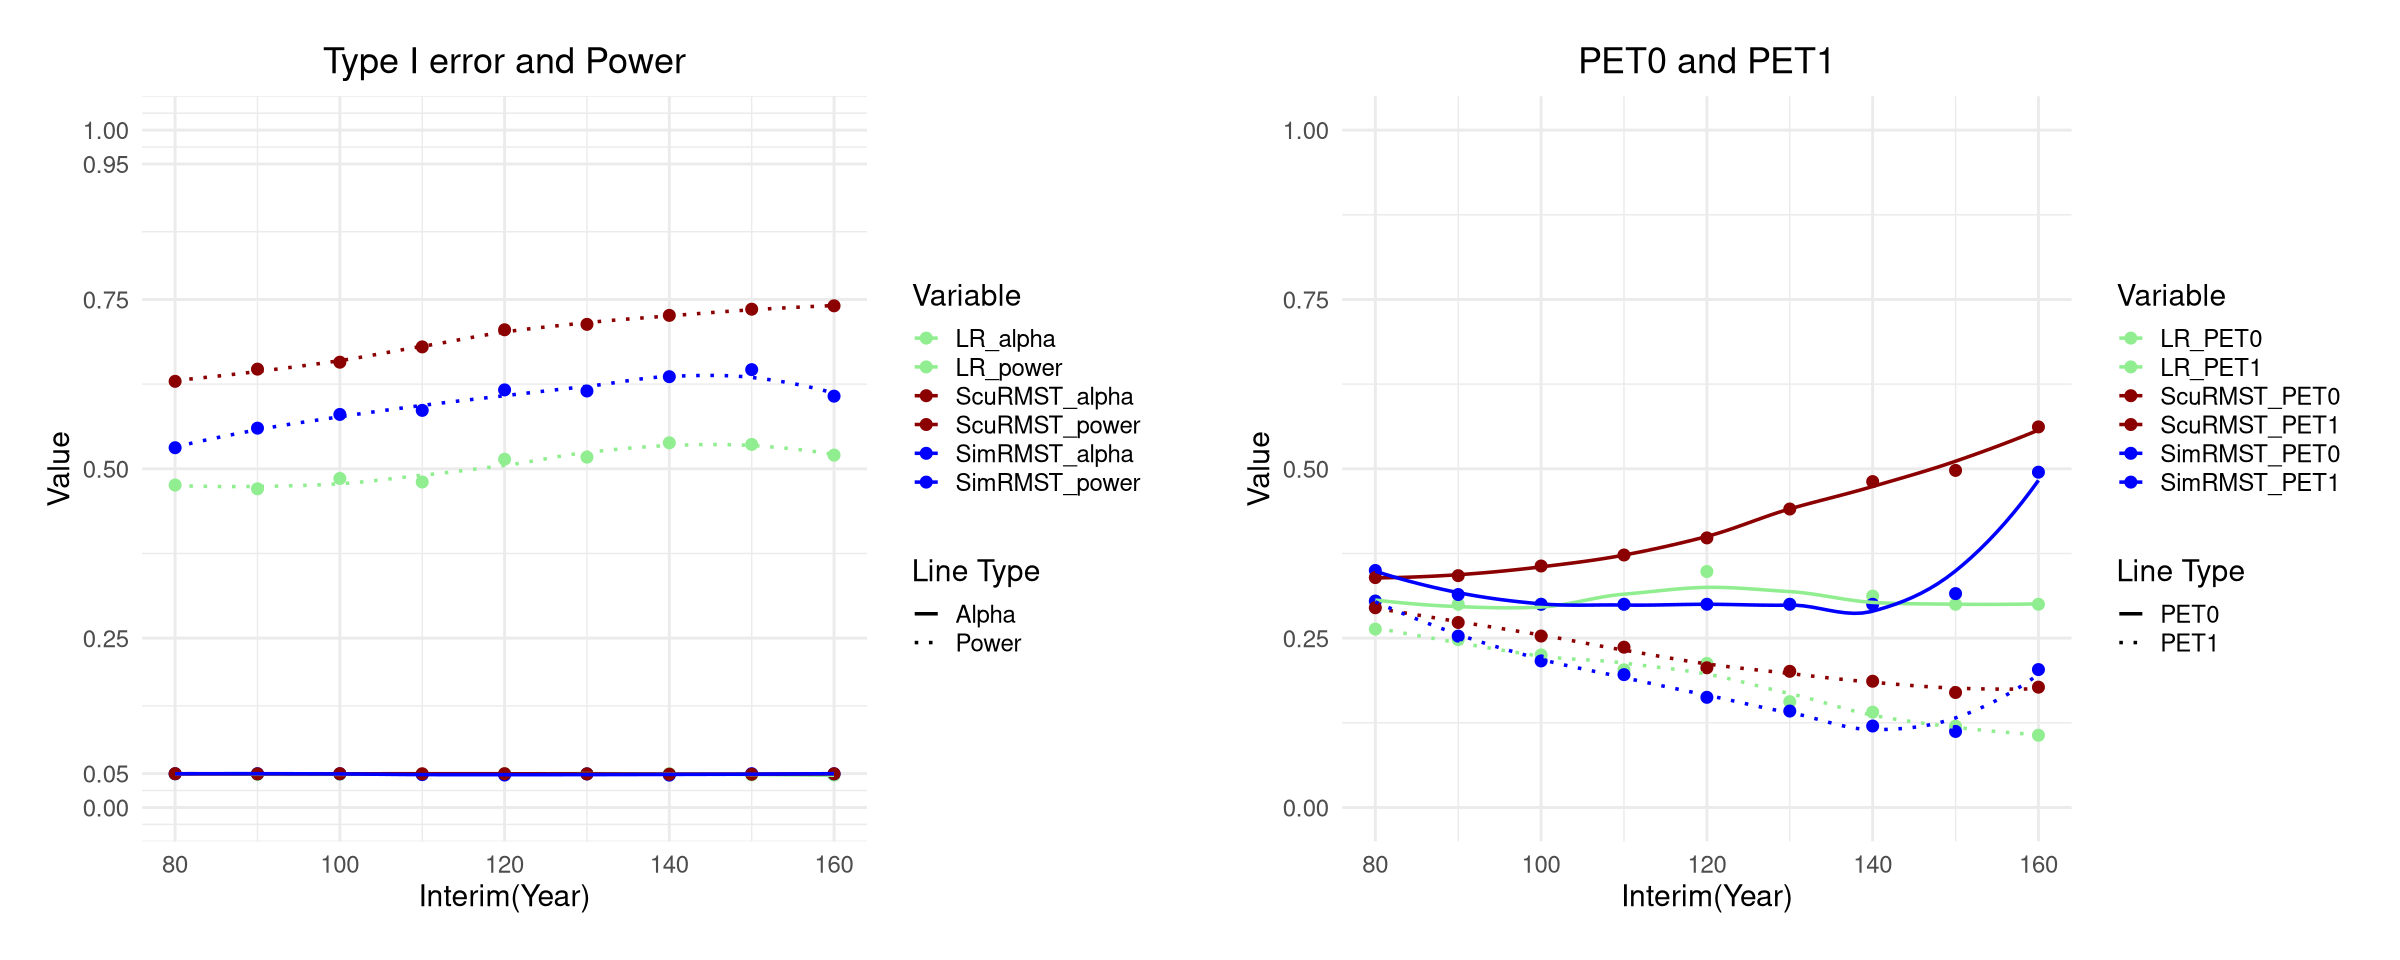

In [ ]:
save(diff_interim_LD, file = '/home/r27user6/RMST_Code/RData/diff_interim_LD.RData')
load('/home/r27user6/RMST_Code/RData/diff_interim_LD.RData')

p2 <- compare_line_plot(data = diff_interim_LD, var_name = 'Interim(Year)')
p2

In [11]:
lambda_H0 <- 1
HR1 <- 1
HR2 <- 0.5
N <- 100
sim_size <- 5000 
n <- ceiling(N / 2) 
r <- 60  # patient recruit rate
acc_time <- N / r
cen_time <- 1
change_time <- 0.5 # The time point between HR1 and HR2
interim <- 0.7 * acc_time
alpha <- 0.05

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim) 

data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                            dist = 'pcw_exp', cen_time = cen_time, HR1 = HR1, HR2 = HR2, 
                            change_time = change_time, arm = 1, interim = interim)
# power of one sided log rank test
log_rank_1 <- log_rank_sim(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)] 
                            ,sim_size = sim_size, n = n, alpha = alpha ,sided = 'greater')
log_rank_1$rejection

# power of one sided RMST difference test
simple_rmst_1 <- RMST_sim_test(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)]
                            ,sim_size = sim_size, tau = 2.5, n = n
                            ,alpha = alpha ,sided = 'greater')
simple_rmst_1$test_result$rejection

[1] 0.3896

[1] 0.3816

------
## 3. Different Recruit Rate
### Constant recruit rate. Smaller value means longer accrual time and interim period

In [7]:
lambda_H0 <- 1.2
HR1 <- 1
HR2 <- 0.6
sim_size <- 10000 
n <- ceiling(200 / 2) 
cen_time <- 1
change_time <- (200 / 90) * 0.3  # The time point between HR1 and HR2
set.seed(2024)
alpha <- 0.05

diff_rec_rate_LD <- foreach(r = seq(40, 130, by = 10), .combine = rbind) %do%
    {
        acc_time <- 200 / r
        interim <- 120 / r 
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(r, result$alpha, result$power, result$PET0, result$PET1)  
    }

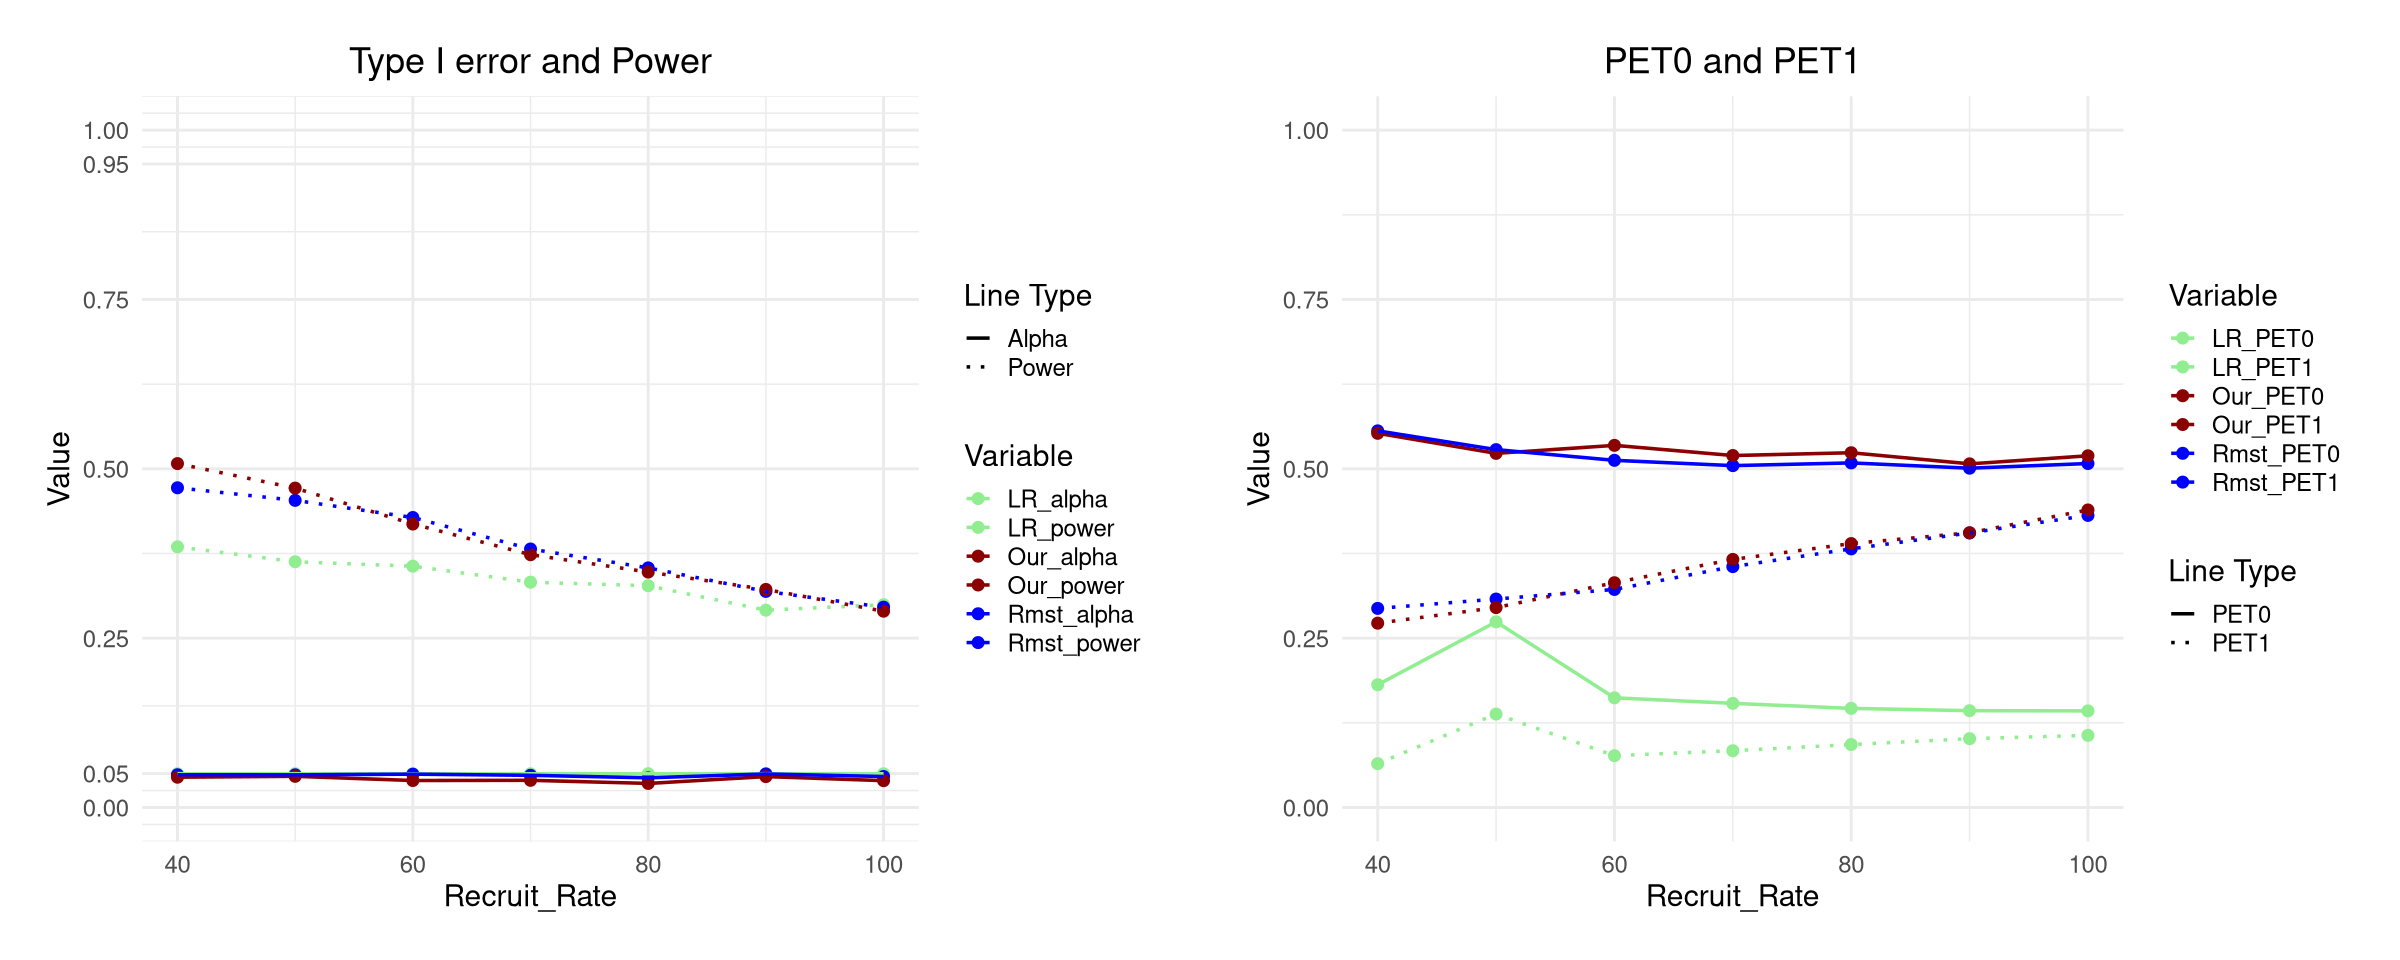

In [8]:
save(diff_rec_rate_LD, file = '/home/r27user6/RMST_Code/RData/diff_rec_rate_LD.RData')
load('/home/r27user6/RMST_Code/RData/diff_rec_rate_LD.RData')

p3 <- compare_line_plot(data = diff_rec_rate_LD[1:7,], var_name = 'Recruit_Rate')
p3

------
## 4. Different Changing Point
#### The time point of HR1 to HR2

In [9]:
lambda_H0 <- 1.2
HR1 <- 1
HR2 <- 0.5
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
set.seed(2024)
alpha <- 0.05

diff_ct_LD <- foreach(ct_rate = seq(0.2, 0.6, by = 0.05), .combine = rbind) %do%
    {
        change_time <- acc_time * ct_rate
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(change_time, result$alpha, result$power, result$PET0, result$PET1)  
    }

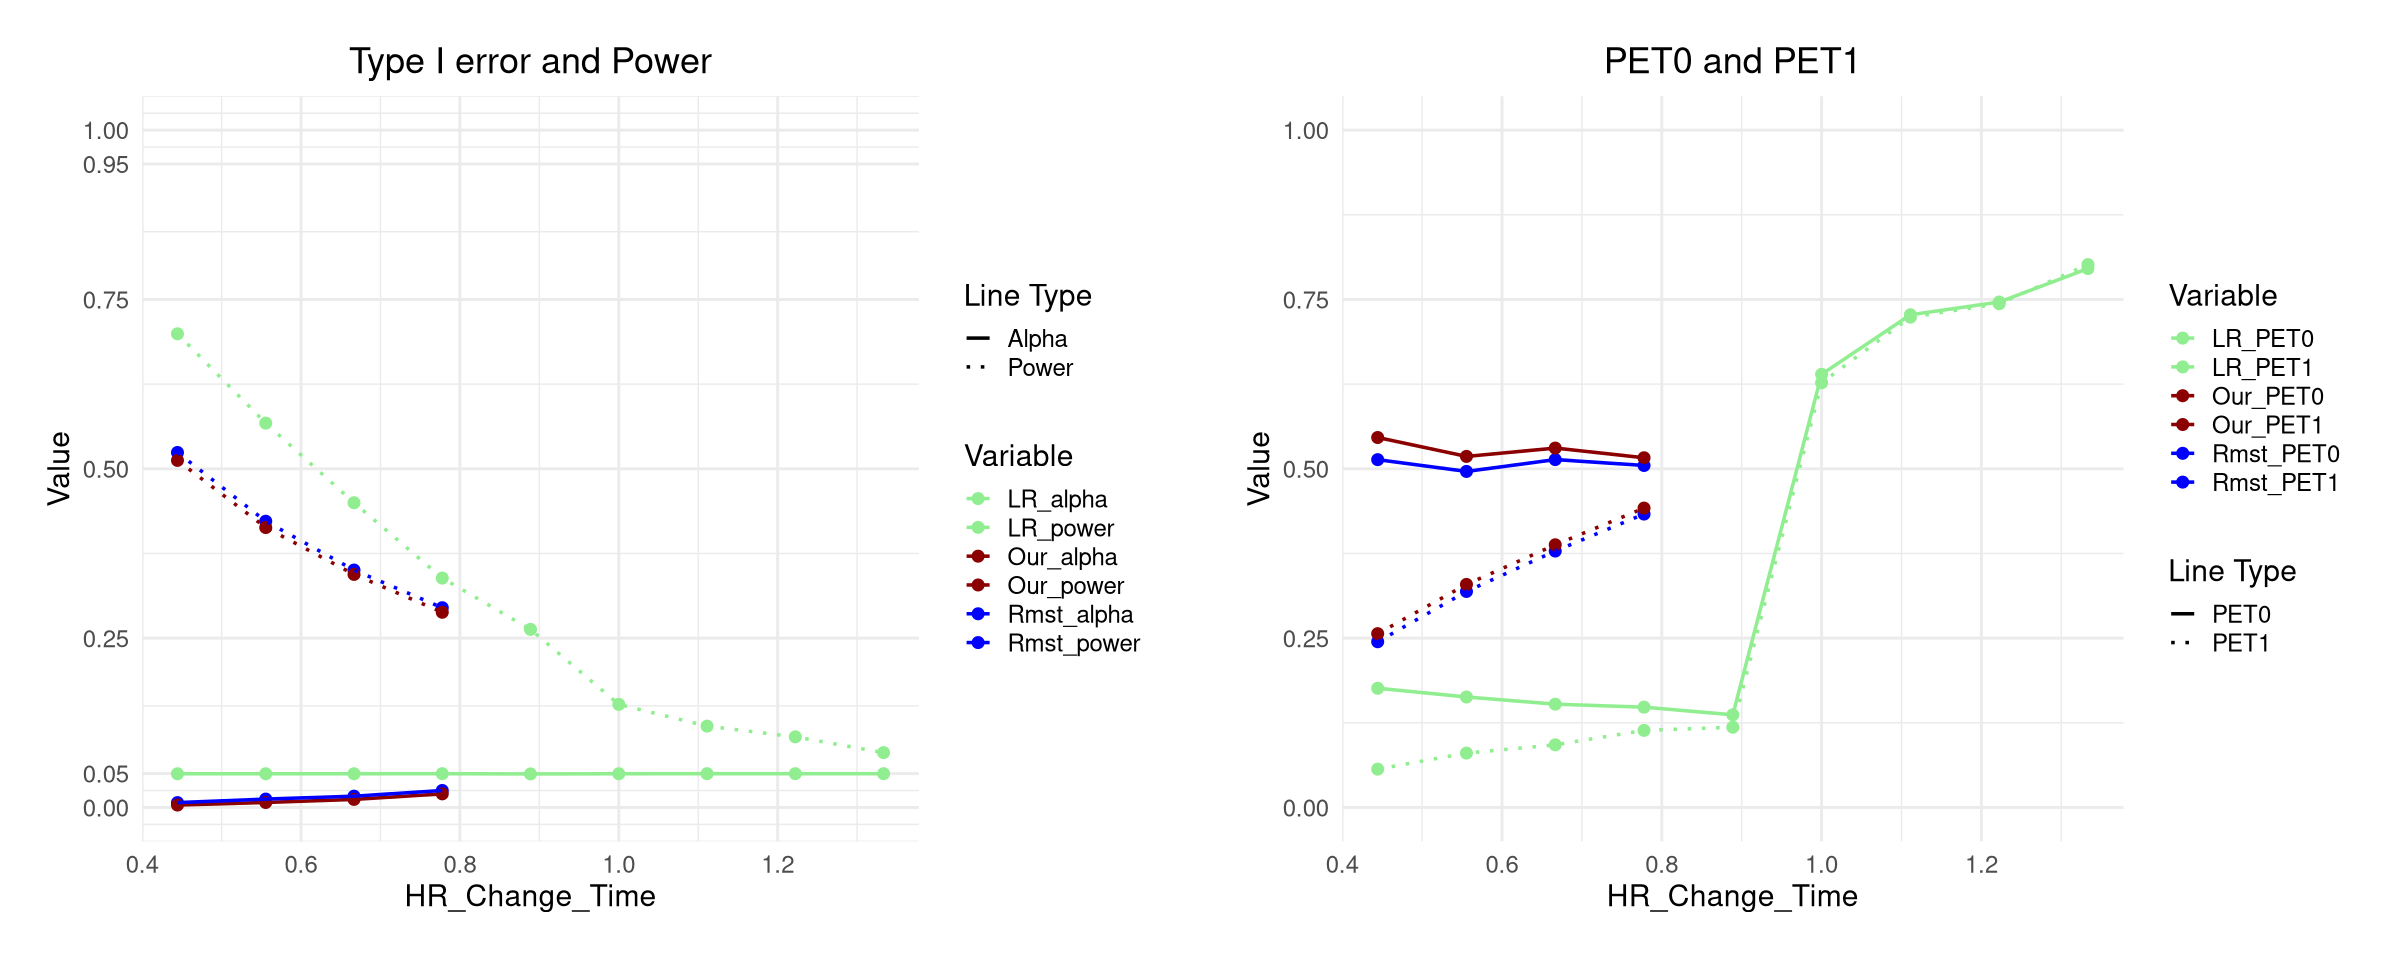

In [10]:
save(diff_ct_LD, file = '/home/r27user6/RMST_Code/RData/diff_ct_LD.RData')
load('/home/r27user6/RMST_Code/RData/diff_ct_LD.RData')

p4 <- compare_line_plot(data = diff_ct_LD, var_name = 'HR_Change_Time')
p4

-----
## 5. Different Follow Up Time : censoring distribution
### Censoring distribution $C \sim U [b , a + b]$, where b is the follow up time.
### We tune b from 0.6 to 1.6

In [11]:
lambda_H0 <- 1.2
HR1 <- 1
HR2 <- 0.5
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90  # patient recruit rate
acc_time <- 200 / r
interim <- 120 / r
change_time <- acc_time * 0.3 # The time point between HR1 and HR2
set.seed(2024)

diff_cen_LD <- foreach(cen_time = seq(0.6, 1.5, by = 0.1), .combine = rbind) %do%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(cen_time, result$alpha, result$power, result$PET0, result$PET1)        
    }

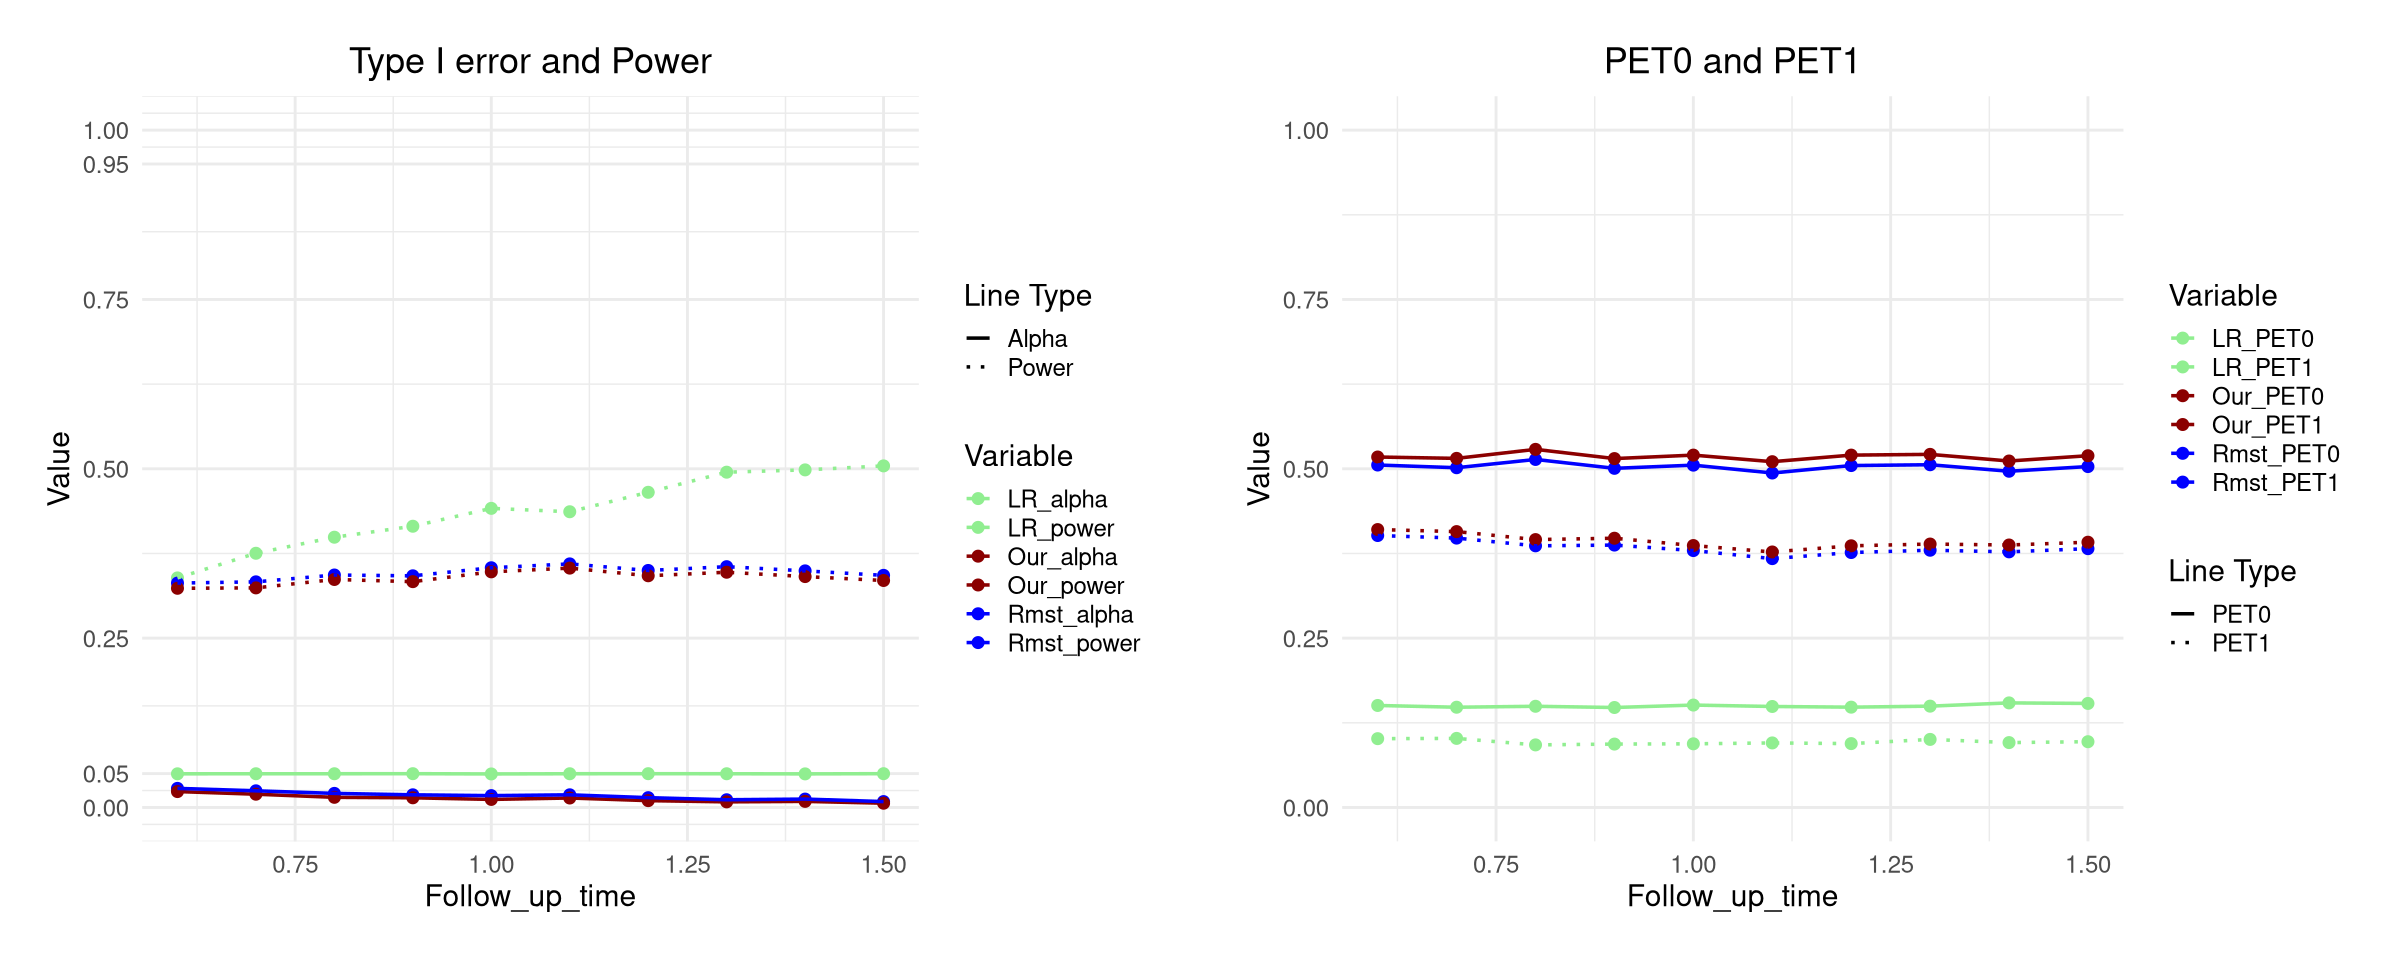

In [12]:
save(diff_cen_LD, file = '/home/r27user6/RMST_Code/RData/diff_cen_LD.RData')
load('/home/r27user6/RMST_Code/RData/diff_cen_LD.RData')

p5 <- compare_line_plot(data = diff_cen_LD, var_name = 'Follow_up_time')
p5

In [13]:
p <- plot_grid(p1,p2,p3,p4,p5, ncol = 1)
ggsave("figures/Comparison/Late_diff.png", plot = p,width = 20, height = 30, limitsize = FALSE)

### the searching range of gamma(in our method) may be too small. no solution
### Larger gamma for complete figures in this file.
-----
# Optimal design

In [ ]:
lambda_H0 <- 1
HR1 <- 1
HR2 <- 0.4
sim_size <- 5000
N <- 220
r <- 120
n <- ceiling(N / 2) 
acc_time <- N/r
cen_time <- 1
change_time <- 0.5  # The time point between HR1 and HR2
alpha <- 0.1
interim <- 0.6 * acc_time
data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim) 
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                            dist = 'pcw_exp', cen_time = cen_time, HR1 = HR1, HR2 = HR2, 
                            change_time = change_time, arm = 1, interim = interim)
# power of one sided RMST difference test
simple_rmst_1 <- RMST_sim_test(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)]
                            ,sim_size = sim_size, tau = 3, n = n ,alpha = alpha ,sided = 'greater')
                            
lr_1 <- log_rank_sim(data_C = data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], sim_size = sim_size,
                            n = n, alpha = alpha ,sided = 'greater')
                        
simple_rmst_1$test_result$rejection
lr_1$rejection

[1] 0.8458

[1] 0.8566

In [7]:
set.seed(2024)
lambda_H0 <- 1
HR1 <- 1
HR2 <- 0.4
sim_size <- 5000 
r <- 120  # patient recruit rate
cen_time <- 1
change_time <- 0.5 # The time point between HR1 and HR2
tau <- 2.5

alpha <- 0.1
power <- 0.85
result_LR <- data.frame()
result_scu <- c()
result_sim <- c()

for (N in seq(from = 200, to = 216, 4))
{
    n <- ceiling(N / 2) 
    acc_time <- N/r
    our_rmst <-  get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                        int_step = 4, lambda_H0 = lambda_H0, H1_type = 'NPH', HR1 = HR1, HR2 = HR2, tau = tau,
                        change_time = change_time, alpha = alpha, power = power, method = 'Complex') 
    res <- our_rmst[, c('PET0','PET1','alpha','power','PET','EN0','EN1','EN','interim_n')]
    res$N <- c(N)
    res$Method <- 'scu_rmst'
    result_scu <- rbind(result_scu, res)
    saveRDS(result_scu, "tem_result_scu.rds")
}

for (N in seq(from = 220, to = 236, 4))
{
    n <- ceiling(N / 2) 
    acc_time <- N/r
    sim_rmst <-  get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                        int_step = 4, lambda_H0 = lambda_H0, H1_type = 'NPH', HR1 = HR1, HR2 = HR2, tau = tau,
                        change_time = change_time, alpha = alpha, power = power, method = 'Simple')     
    res <- sim_rmst[, c('PET0','PET1','alpha','power','PET','EN0','EN1','EN','interim_n')]
    res$N <- c(N)
    res$Method <- 'sim_rmst'
    result_sim <- rbind(result_sim, res)
    saveRDS(result_sim, "tem_result_sim.rds")
 }

for (N in seq(220, 236, by = 4))
{
    n <- ceiling(N / 2) 
    acc_time <- N / r 
    lr_opt <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                        int_step = 4, lambda_H0 = lambda_H0, H1_type = 'NPH', HR1 = HR1, HR2 = HR2, 
                        change_time = change_time, alpha = alpha, power = power, method = 'logrank')   
    res <- lr_opt[, c('PET0','PET1','alpha','power','PET','EN0','EN1','EN','interim_n')]
    res$N <- N
    res$Method <- 'log_rank'
    result_LR <- rbind(result_LR, res)
    saveRDS(result_LR, "tem_result_lr.rds")
}

result_LR
result_sim
result_scu


,PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n,N,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.0000,0.0000,0.0000,0.0000,0.0000,NA,NA,NA,NA,220,log_rank
2,0.0000,0.0000,0.0000,0.0000,0.0000,NA,NA,NA,NA,224,log_rank
10722,0.3000,0.1116,0.0982,0.8502,0.2058,206.1600,219.8755,213.0178,156,228,log_rank
10874,0.3036,0.1108,0.0996,0.8506,0.2072,207.9549,223.2246,215.5898,153,232,log_rank
10576,0.3190,0.1208,0.0982,0.8514,0.2199,208.6936,225.6595,217.1766,151,236,log_rank


,PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n,N,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.0000,0.0000,0.0000,0.0000,0.0000,NA,NA,NA,NA,220,sim_rmst
4446,0.3084,0.1116,0.0952,0.8544,0.2100,201.0550,215.6970,208.3760,150,224,sim_rmst
44461,0.3068,0.1120,0.0966,0.8502,0.2094,204.4378,219.3984,211.9181,152,228,sim_rmst
4348,0.3242,0.1168,0.0964,0.8524,0.2205,206.3234,222.7494,214.5364,153,232,sim_rmst
4447,0.3142,0.1132,0.0964,0.8514,0.2137,209.1045,226.3101,217.7073,151,236,sim_rmst


,PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n,N,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.0000,0.0000,0.0000,0.0000,0.0000,NA,NA,NA,NA,200,scu_rmst
31,0.3318,0.1406,0.0960,0.8520,0.2362,183.2957,195.2266,189.2611,142,204,scu_rmst
2728,0.3112,0.1334,0.0986,0.8518,0.2223,186.5894,198.8221,192.7058,140,208,scu_rmst
2122,0.3128,0.1372,0.0994,0.8536,0.2250,189.7286,202.2314,195.9800,141,212,scu_rmst
2328,0.3380,0.1390,0.0992,0.8504,0.2385,192.4752,206.3256,199.4004,147,216,scu_rmst


In [3]:
readRDS("tem_result_scu.rds")

,PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n,N,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2021,0.4334,0.1344,0.0498,0.8010,0.2839,183.5944,208.7104,196.1524,136,220,scu_rmst
406,0.3962,0.1394,0.0498,0.8014,0.2678,186.5385,212.1158,199.3271,127,226,scu_rmst


_________________

In [6]:
set.seed(2024)
lambda_H0 <- 1
HR1 <- 1
HR2 <- 0.4
sim_size <- 5000 
r <- 120  # patient recruit rate
cen_time <- 1
change_time <- 0.5 # The time point between HR1 and HR2

N <- 230
n <- ceiling(N / 2) 
alpha <- 0.1
tau_f <- 2.5
acc_time <- N / r
int_factor <- 0.65  # Each time interim sample size increase by 6
interim_list <- int_factor * acc_time

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 0, interim = interim_list)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 1, interim = interim_list) 
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                            dist = 'pcw_exp', cen_time = cen_time, HR1 = HR1, HR2 = HR2, 
                            change_time = change_time, arm = 1, interim = interim_list)
interim <- interim_list
rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim, sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim, sim_size = sim_size)
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)], tau = tau_f, sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)], tau = tau_f, sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)

best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                            int_n = interim * r, fin_n = N, sim_size = sim_size, method = 'Simple',
                            alpha = alpha)
best_our                         


,m1,m2,q1,q2,gamma,PET0,PET1,alpha,power
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4347,-0.03797097,0.1272498,-Inf,-Inf,0,0.3224,0.1172,0.0998,0.8534
